# CRISP-DM Methodology
CRISP-DM stands for Cross Industry Standard Process for Data Mining and is a 1996 methodology created to shape Data Mining projects. It consists of 6 steps to conceive a Data Mining project and they can have cycle iterations according to developers’ needs. Those steps are Business Understanding, Data Understanding, Data Preparation, Modeling, Evaluation, and Deployment.

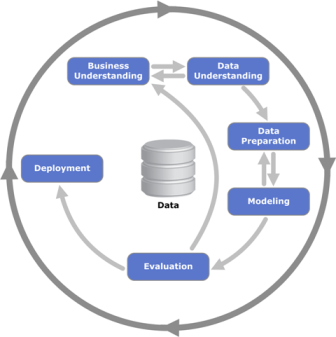

# 1. Business Understanding
Coronavirus disease (COVID-19) is an inflammation disease from a new virus. The disease causes respiratory ailment (like influenza) with manifestations, for example, cold, cough and fever, and in progressively serious cases, the problem in breathing. COVID-2019 has been perceived as a worldwide pandemic and a few examinations are being led utilizing different numerical models to anticipate the likely advancement of this pestilence. These numerical models dependent on different factors and investigations are dependent upon potential inclination. Here, we predict the number of cases using Prophet model.

# 2. Data Understanding

The data is gathered from [COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19).

In [1]:
import numpy as np
import pandas as pd

# Visualization
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore Warnings on Prophet
import warnings  
warnings.filterwarnings('ignore')

In [20]:
covid = pd.read_csv("../input/covidcleaned/cleansed.csv")
del covid["Date.1"]
covid = covid[covid.Cases > 4]
covid = covid.reset_index(drop=True)
covid

,Date,Cases
0,2020-03-08,6
1,2020-03-09,19
2,2020-03-10,27
3,2020-03-11,34
4,2020-03-12,34
...,...,...
348,2021-02-19,1263299
349,2021-02-20,1271353
350,2021-02-21,1278653
351,2021-02-22,1288833


In [21]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    353 non-null    object
 1   Cases   353 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.6+ KB


In [22]:
covid.describe()

,Cases
count,3.530000e+02
mean,3.287327e+05
std,3.626058e+05
min,6.000000e+00
25%,2.881800e+04
50%,1.747960e+05
75%,5.225810e+05
max,1.298608e+06


In [23]:
covid['Date'] = pd.to_datetime(covid['Date'], format = '%Y-%m-%d')

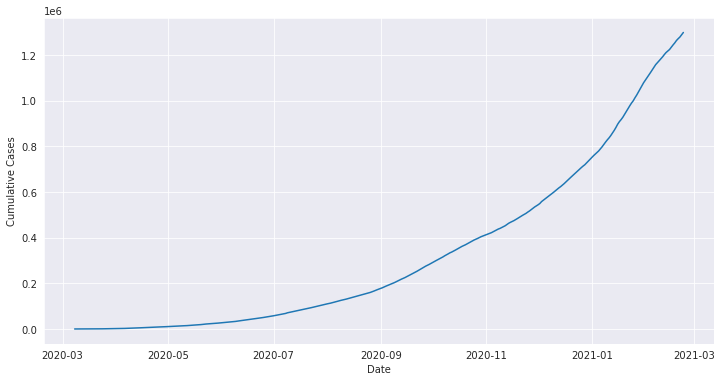

In [26]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=covid, x="Date", y="Cases")
plt.xlabel('Date')
plt.ylabel('Cumulative Cases')
plt.show()

# 3. Data Preparation

In [27]:
# Define features and target
X = covid["Date"]
y = covid["Cases"]

In [28]:
from sklearn.model_selection import train_test_split

# Split data into 90% training data and 10% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,shuffle=False)

In [29]:
train_data = {'ds': X_train, 'y': y_train}
train_data = pd.DataFrame(train_data)
train_data['ds'] = pd.to_datetime(train_data['ds'])
train_data.shape

(317, 2)

In [30]:
test_data = {'ds': X_test, 'y': y_test}
test_data = pd.DataFrame(test_data)
test_data['ds'] = pd.to_datetime(test_data['ds'])
test_data.shape

(36, 2)

# 4. Modeling

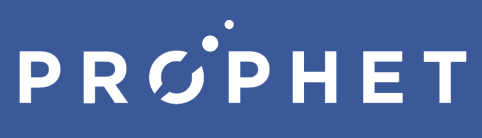

Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

We fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor. Then we call its fit method and pass in the historical dataframe.

In [31]:
from fbprophet import Prophet

m = Prophet(interval_width=0.95, 
            changepoint_prior_scale=0.5,
            changepoint_range=0.95)

m.add_country_holidays(country_name='ID')
m.fit(train_data)

In [32]:
m.train_holiday_names

0               New Year's Day
1             Chinese New Year
2     Ascension of the Prophet
3                    Labor Day
4           Ascension of Jesus
5            Buddha's Birthday
6                Pancasila Day
7                  Eid al-Fitr
8             Independence Day
9             Islamic New Year
10        Birth of the Prophet
11                   Christmas
12      Feast of the Sacrifice
dtype: object

Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. We use Prophet.make_future_dataframe to predict the next 36 days in order to compare it with its testing data.

In [33]:
future = m.make_future_dataframe(periods=36)
future

,ds
0,2020-03-08
1,2020-03-09
2,2020-03-10
3,2020-03-11
4,2020-03-12
...,...
348,2021-02-19
349,2021-02-20
350,2021-02-21
351,2021-02-22


The predict method will assign each row in future a predicted value which it names yhat. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [34]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
348,2021-02-19,1.228926e+06,1.189200e+06,1.270504e+06
349,2021-02-20,1.239243e+06,1.195226e+06,1.282459e+06
350,2021-02-21,1.249097e+06,1.203832e+06,1.294163e+06
351,2021-02-22,1.258564e+06,1.211586e+06,1.306569e+06
352,2021-02-23,1.268200e+06,1.219018e+06,1.318692e+06


# 5. Evaluation

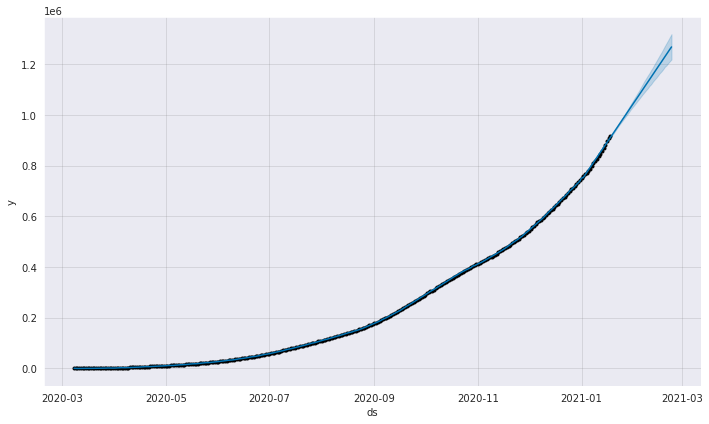

In [35]:
confirmed_forecast_plot = m.plot(forecast)

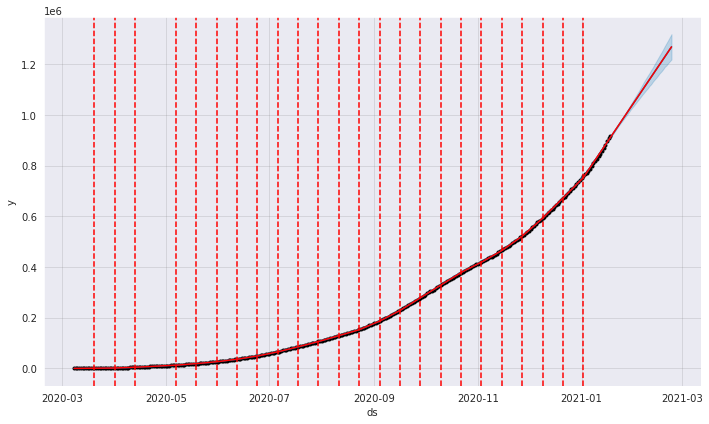

In [36]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [37]:
forecast_after = forecast[forecast["ds"] > "2021-01-18"] 

In [38]:
fig = go.Figure(data=[
    go.Bar(name='Total Cases', x=train_data['ds'], y=train_data['y']),
    go.Bar(name='Total Cases Forecasted', x=forecast_after['ds'], y=forecast_after['yhat_upper'])
])

fig.update_layout(barmode='group', title='Indonesian Cases + Forecasted Cases')
fig.show()

In [39]:
fig = go.Figure(data=[
    go.Bar(name='Total Cases', x=train_data['ds'], y=train_data['y']),
    go.Bar(name='Future Cases', x=test_data['ds'], y=test_data['y'])
])

fig.update_layout(barmode='group', title='Indonesian Cases + Future Cases')
fig.show()

In [40]:
preds = {'ds': forecast_after["ds"], 'y': forecast_after["yhat_upper"]}
preds = pd.DataFrame(preds)
preds

,ds,y
317,2021-01-19,9.228300e+05
318,2021-01-20,9.329890e+05
319,2021-01-21,9.434134e+05
320,2021-01-22,9.537641e+05
321,2021-01-23,9.641855e+05
322,2021-01-24,9.749754e+05
323,2021-01-25,9.850267e+05
324,2021-01-26,9.961417e+05
325,2021-01-27,1.007749e+06
326,2021-01-28,1.019335e+06


In [41]:
concatenated = pd.concat([test_data.assign(dataset='Actual'), preds.assign(dataset='Predicted')])

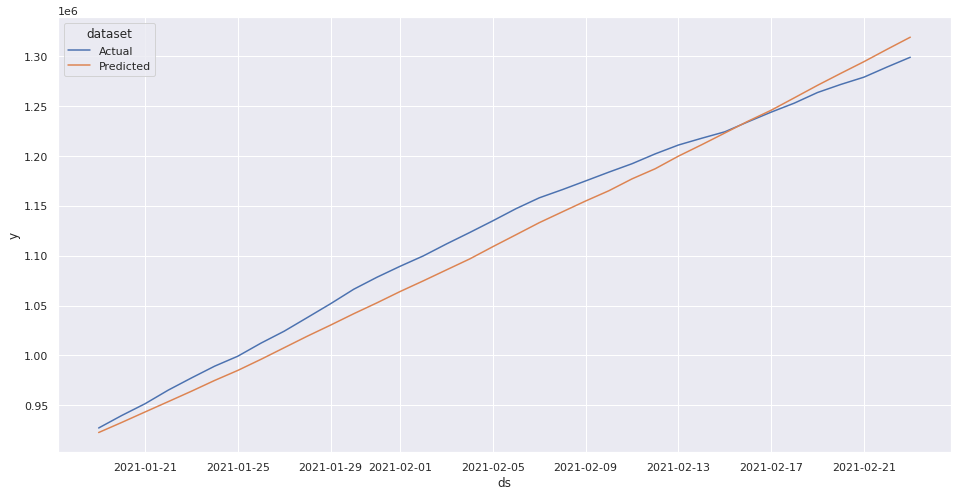

In [48]:
sns.set(rc={'figure.figsize':(16, 8)})
sns.lineplot(x='ds', y='y', data=concatenated, hue='dataset')
plt.show()

# 5.1 Scoring Metrics

**1. Mean Absolute Error**

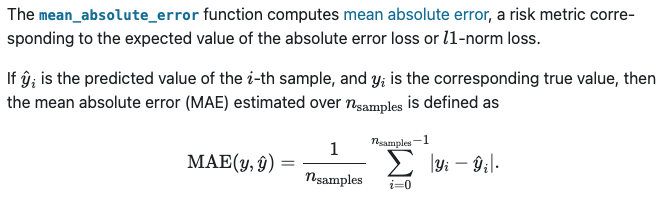

**2. Mean Squared Error**

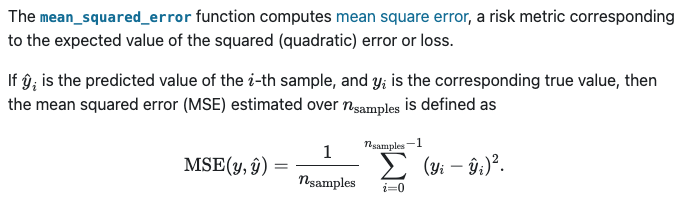

**3. Max Error**

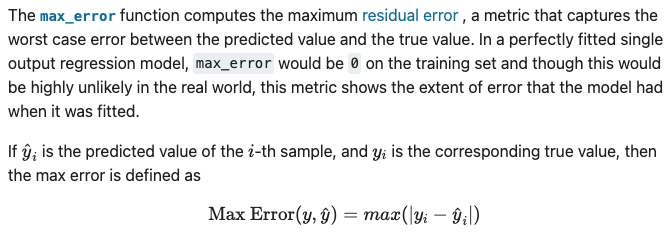

**4. R2 Score**

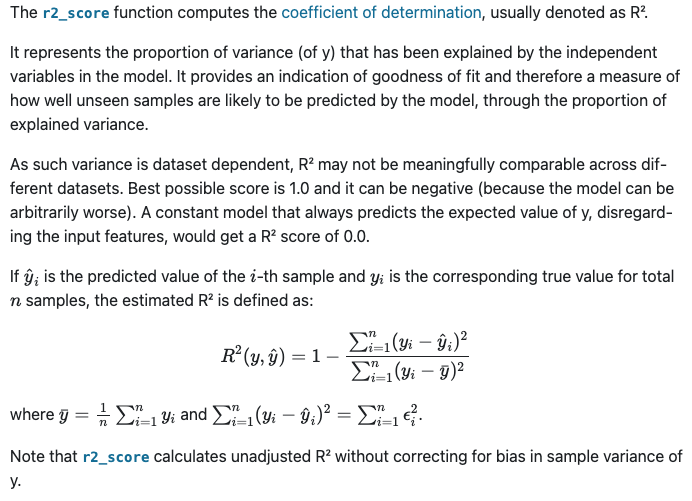

*Source: https://scikit-learn.org/stable/modules/model_evaluation.html*

In [44]:
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("Max Error: " + str(max_error(test_data["y"], forecast_after["yhat_upper"])))
print("Mean Absolute Error: " + str(mean_absolute_error(test_data["y"], forecast_after["yhat_upper"])))
print("R2 Score: " + str(r2_score(test_data["y"], forecast_after["yhat_upper"])))
print("Root Mean Square Error: " + str(mean_squared_error(test_data["y"], forecast_after["yhat_upper"], squared=False)))

# Max Error: 28118.027695475845
# Mean Absolute Error: 16564.30994189874
# Mean Squared Error: 348081999.9746246
# R2 Score: 0.9713152612026821

Max Error: 26465.904484098544
Mean Absolute Error: 15692.127565745186
R2 Score: 0.9746070059119398
Root Mean Square Error: 17553.846195578553


# 6. The Future

In [49]:
covid = covid.rename(columns={"Date": "ds", "Cases": "y"})

In [50]:
m = Prophet(interval_width=0.95, 
            changepoint_prior_scale=0.5,
            changepoint_range=0.95)

m.add_country_holidays(country_name='ID')
m.fit(covid)

In [52]:
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

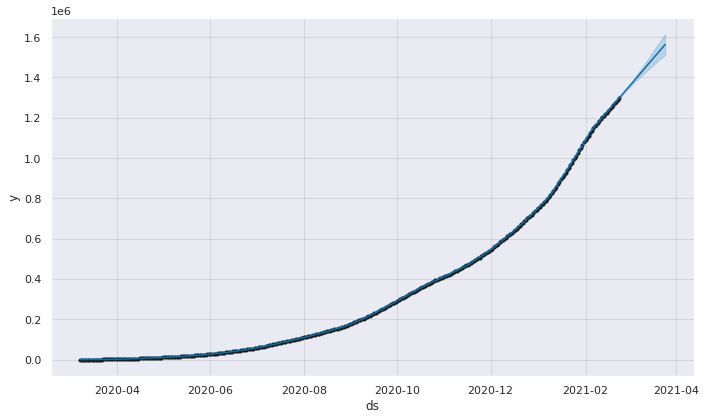

In [53]:
fig1 = m.plot(forecast)

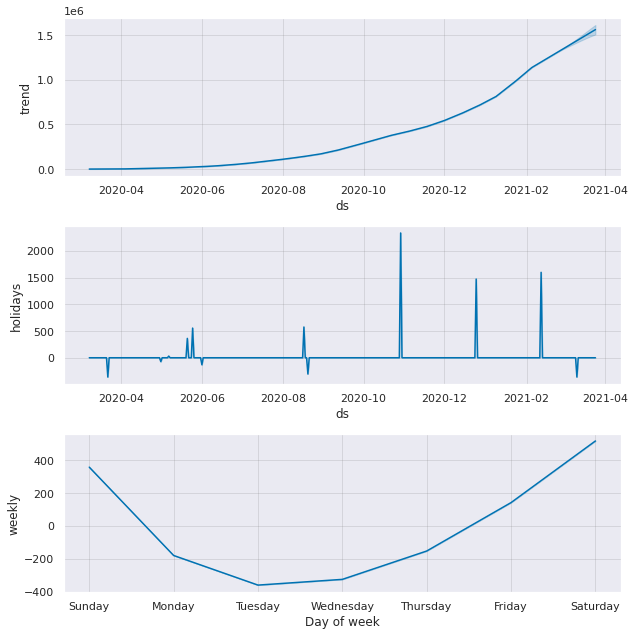

In [54]:
fig2 = m.plot_components(forecast)

In [55]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)